In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as pt
import seaborn as sns
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bostonhoustingmlnd/housing.csv
/kaggle/input/titanic/train_data.csv
/kaggle/input/titanic/test_data.csv


# Importing Data from the link :
Link - https://www.kaggle.com/schirmerchad/bostonhoustingmlnd

In [2]:
input_ads = pd.read_csv('../input/bostonhoustingmlnd/housing.csv')

#-----------------------------------------------------------------
print(input_ads.shape)
input_ads.head()

(489, 4)


,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0


# Null Check

In [3]:
pd.DataFrame(input_ads.isnull().sum()).T

,RM,LSTAT,PTRATIO,MEDV
0,0,0,0,0


# Description of target variable

In [4]:
input_ads['MEDV'].describe()

count    4.890000e+02
mean     4.543429e+05
std      1.653403e+05
min      1.050000e+05
25%      3.507000e+05
50%      4.389000e+05
75%      5.187000e+05
max      1.024800e+06
Name: MEDV, dtype: float64

# Manipulation of dataset into train and test 

In [5]:
X = input_ads[[cols for cols in list(input_ads.columns) if 'MEDV' not in cols]]
y = input_ads['MEDV']

X, X_test, y, y_test = train_test_split(X, y, test_size=0.30, random_state=100)

#--------------------------------------------------------------------------------
#Scaling the datasets
scaler = StandardScaler()

X_arr = scaler.fit_transform(X)
X_test_arr = scaler.fit_transform(X_test)

y_arr = np.array(y).reshape(X_arr.shape[0],1)
y_test_arr = np.array(y_test).reshape(X_test_arr.shape[0],1)

#--------------------------------------------------------------------------------
print(X_arr.shape)
print(X_test_arr.shape)
print(y_arr.shape)

(342, 3)
(147, 3)
(342, 1)


# Manual Gradient Boosting Code

## Defining some important UDF's for the training of gradient boosting

In [6]:
from sklearn.tree import DecisionTreeRegressor

#---------------------------------------------------------------------------------------------------------
#Loss func
def loss_calc(y_true,y_pred):
    
    loss = (1/len(y_true)) * 0.5*np.sum(np.square(y_true-y_pred))
        
    return loss

#---------------------------------------------------------------------------------------------------------
#Gradient Calc
def gradient_calc(y_true,y_pred):
    
    grad = -(y_true-y_pred)
    
    return grad

#---------------------------------------------------------------------------------------------------------
#The base estimator
def tree_creator(r_state,X,y):
    
    d_tree = DecisionTreeRegressor(random_state=r_state,criterion='mse',
                                    max_depth=2,min_samples_split=5,
                                    min_samples_leaf=5,max_features=3)
    d_tree.fit(X,y)
    
    return d_tree

#---------------------------------------------------------------------------------------------------------
#Predicting through gradient boosting regression
def predict_grad_boost(models_tray,alpha,test_x=X_test_arr,train_y=y_arr):
    
    initial_pred = np.array([np.mean(train_y)] * len(test_x))
        
    final_pred = initial_pred.reshape(len(initial_pred),1)
    #print(final_pred.shape)
    
    for i in range(len(models_tray)):
        
        model = models_tray[i]
        temp_pred = (model.predict(test_x)).reshape(len(test_x),1)
        #print(temp_pred.shape)
        final_pred -= alpha * temp_pred
    
    return final_pred
    

## UDF for Gradient Boosting training

In [7]:
def grad_boost_train(train_x,train_y,alpha=0.01,r_state=100,n_iters=101):

    model_tray = [] #Tray to collect the trained boosted stage estimators
    loss_counter = [] #Tray for loss capture

    
    initial_pred = np.array([np.mean(train_y)] * len(train_y))

    print('Initial val :',initial_pred.shape)
    model_pred = initial_pred.reshape(len(initial_pred),1)

    for epoch in range(n_iters): #Unit iteration

        if epoch%100==0:
            print('#---------- Epoch number :',epoch,' -----------#')
        
        #Calculating loss
        loss = loss_calc(y_true=train_y,
                         y_pred=model_pred)

        loss_counter.append(loss)
        
        #Calculating the gradient (residuals)
        grads = gradient_calc(y_true=train_y,
                              y_pred=model_pred)
        #print(grads.shape)
        #Building the regression tree on the gradient (residuals)
        tree_grad = tree_creator(r_state=r_state,
                                 X=train_x,
                                 y=grads)
        #print(train_x.shape)
        #print(tree_grad.predict(train_x).shape)
        
        #Predicting the residuals according to the tree fit above
        pred_m = (tree_grad.predict(train_x)).reshape(len(train_x),1)
        
        #Updating model through learning rate
        model_pred -= alpha * pred_m
        
        #Appending the model into tray
        model_tray.append(tree_grad)
        
    return model_tray,loss_counter,initial_pred

## Invoking the gradient boosting training UDF

In [8]:
#-----------------------------------------------------------------------------------------------------------------------
#Defining some hyper-params
n_estimators = 1001 #No of boosting steps
alpha =0.01 #Learning rate

#Training gradient boosting regression
models_list,loss_counter,initial_pred = grad_boost_train(train_x=X_arr,
                                                         train_y=y_arr,
                                                         alpha=alpha,
                                                         r_state=100,
                                                         n_iters=n_estimators)

Initial val : (342,)
#---------- Epoch number : 0  -----------#
#---------- Epoch number : 100  -----------#
#---------- Epoch number : 200  -----------#
#---------- Epoch number : 300  -----------#
#---------- Epoch number : 400  -----------#
#---------- Epoch number : 500  -----------#
#---------- Epoch number : 600  -----------#
#---------- Epoch number : 700  -----------#
#---------- Epoch number : 800  -----------#
#---------- Epoch number : 900  -----------#
#---------- Epoch number : 1000  -----------#


## Plotting the Loss curve (There should be a decrease in training loss over boosting rounds)

[Text(0.5, 0, 'Number of boosting rounds'),
 Text(0, 0.5, 'Loss'),
 Text(0.5, 1.0, 'Loss vs Boosting rounds plot')]

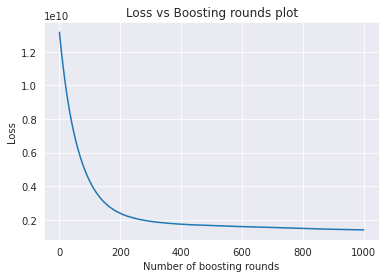

In [9]:
sns.set_style('darkgrid')
ax = sns.lineplot(x=range(n_estimators),y=loss_counter)
ax.set(xlabel='Number of boosting rounds',ylabel='Loss',title='Loss vs Boosting rounds plot')

### Insights - We see that the loss decreases sharply after ~150 boosting rounds then flattens for a long period of time indicating that the model is approaching the global minima in terms of the loss function

## Predicting on the test dataset using the manual training above (Only the trained residual models are passed) 

In [10]:
manual_gbm_pred = predict_grad_boost(models_tray=models_list, #Passing the fitted estimators into the predict function
                                     alpha=alpha, #The alpha val used during training
                                     test_x=X_test_arr) #Test dataset
manual_gbm_pred.shape

(147, 1)

## Evaluating the predictions from the manual gradient boosting model

In [11]:
print('MSE of test set :',mean_squared_error(y_test_arr,manual_gbm_pred))
print('RMSE of test set :',np.sqrt(mean_squared_error(y_test_arr,manual_gbm_pred)))

MSE of test set : 4235465698.4821563
RMSE of test set : 65080.455579860194


# Benchmarking against sklearn implementation of gradient boosting

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

skl_gbm = GradientBoostingRegressor(random_state=100,n_estimators=1001,criterion='mse',
                                    max_depth=2,min_samples_split=5,
                                    min_samples_leaf=5,max_features=3)

#-------------------------------------------------------------------------------
skl_gbm.fit(X_arr,y_arr)
skl_pred = skl_gbm.predict(X_test_arr)

#-------------------------------------------------------------------------------
print('MSE of test set :',mean_squared_error(y_test_arr,skl_pred))
print('RMSE of test set :',np.sqrt(mean_squared_error(y_test_arr,skl_pred)))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MSE of test set : 5234965332.037068
RMSE of test set : 72353.06028107635


# Final Comments :
1. The manual implementation of the gradient boosting algorithm is providing similar results to its sklearn counterpart (Even better in terms of MSE and RMSE metric) 
2. This notebook can be easily scaled to other datasets as well for robust benchmarking

# END